<a href="https://colab.research.google.com/github/edelauna/a-notebook-for-your-augury/blob/main/A_Notebook_for_your_Augury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Notebook For Your Augury
By: Elliott de Launay

Template to make machine learning a bit easier to follow and repeatable.

Github: [A Notebook For Your Augury](https://github.com/edelauna/a-notebook-for-your-augury)

Python's a funny language, will try out a build as we go kind of style.

How To Use:
* Best to go cell by cell
* Cell's are organized so that at the top there is some kind of `ALL_CAPS` variable which is either an array of Dicts or Dict, wit the intent of passing this as input to the functions specified.
* After the config, code is marked betwen a block:
```
  # Some Config here
  """"
  """"
  # There will be some code here which is the mechanics of what's being performed
  # This code then dynamically added to the Augury class 
  #    (In hopes it makes it easier to follow along)
  """"
  """"
  # Then the actual code which runs the above function with the configs
```

Goal:
* Automate:
  * Transformations applied to Training Data, also get applied test.
  * Evaluate 3 Models
    * Included a 4th Model (KMeans) as _experiemental_
  * Select best performing model to be used for Test

In [1]:
### Initialization
class Augury:
  def constructor():
    """
    Decorator which adds funcs to this class    
    """
    def decorator(*funcs):
      for func in funcs:
        setattr(__class__, func.__name__, func)
    return decorator
  def _attr(self, *readers, overwrite=True, **writers):
    """
    Returns the relevent self.attr.
    Will also set a value if passed with a value.
      Parameters
      ----------
      readers : str
          attr to return
      overwrite : bool
          if False, will not set a value, if a value exists
      writers : Dict
          key as attr to return, value as value to set.
      Returns
      ----------
      tuple of ordered attrs
    """
    _attrs = []
    for attr in readers:
      _attrs.append(getattr(self,attr)) if hasattr(self, attr) else _attrs.append(None)
    for attr in writers:
      if not hasattr(self, attr) or overwrite:
        setattr(self, attr, writers[attr])
      _attrs.append(getattr(self,attr))
    return tuple(_attrs)
  def _hash(self, hash, *keys):
    """
    Helper function to destructure a hash.
    ...didn't end up using this as much
      Parameters
      ----------
      hash : Dictionary
          hash to destructure
      keys : str
          values at key will be returned.
      Returns
      ----------
      tuple of ordered hash values
    """
    results = []
    for key in keys:
      results.append(hash[key]) if key in hash else results.append(None)
    return tuple(results)

# Setting up cache for some longer running functions
import os
AUGURY_CACHE=".augury/.cache"
os.environ["AUGURY_CACHE"]=AUGURY_CACHE
! mkdir -p $AUGURY_CACHE

# Setting main variable to hold it all
augur = Augury()

## Pipeline
The goal of this notebook is to provide a template for machine learning modelling when working with "simple" Continous and Categorical data. The notebook will perform the following:
1. Read in Data
2. Explore Data
    1. Set Label
    1. Continous Features
        1. Handle Nulls
        1. Cap and Floor Outliers
    2. Categorical Features
        1. Handle Nulls
    3. Feature Engineering
        1. Transform Skewed Features
        2. Transform to Numerical Indicators
1. Feature Scaling & Optimal Count
2. Principal Component Analysis
1. Train / Validation Split
3. Model Selection
    1. Hyperparameter Tuning
    1. Fit
    1. Evaluation
4. Test


## Read in Data
This notebook is prioritized to run in Google Colab, so incorporates mounting a Google Drive, and then connecting to Kaggle.

In [2]:
# Google Drive Block
from google.colab import drive
drive.mount('/content/drive')

# Review and Adjust as required
# Download .json from Kaggle: https://www.kaggle.com/docs/api 
# see: #Authentication section
KAGGLE_BASE_PATH="/content/drive/MyDrive/Kaggle/"
KAGGLE_JSON_PATH=KAGGLE_BASE_PATH + "kaggle.json"
! pip install -q kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir -p ~/.kaggle && \
cp $KAGGLE_JSON_PATH ~/.kaggle/ && \
chmod 600 ~/.kaggle/kaggle.json && \
kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          13824        400  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1510         80  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           2589         86  1.0              
devansodariya/student-performance-data       

In [4]:
! kaggle competitions download -c 'spaceship-titanic'

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Check the path - this block might not be needed if not usin Kaggle
TRAIN_DATA_ZIP_PATH="spaceship-titanic.zip"
!mkdir -p /train && \
unzip -o $TRAIN_DATA_ZIP_PATH -d /train

Archive:  spaceship-titanic.zip
  inflating: /train/sample_submission.csv  
  inflating: /train/test.csv         
  inflating: /train/train.csv        


In [6]:
import pandas as pd
# Confirm this path
TRAIN_PATH="/train/train.csv"
TEST_PATH="/train/test.csv"
training_data = pd.read_csv(TRAIN_PATH)
training_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
"""
Reads in data from os.
Requires pandas.
"""
def set_data_from_path(self, pd=pd, **kwargs):
  for kwarg in kwargs:
    assert kwarg.startswith('data_'), "Passed kwargs must start with 'data_'"
    self._attr(**{kwarg:pd.read_csv(kwargs[kwarg])})
Augury.constructor()(set_data_from_path)
"""
"""
augur.set_data_from_path(data_raw=TRAIN_PATH)
augur.data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Explore Data

### Set Label
Review the label and specify whether the label is `categorical` or `continous`. 

In [8]:
LABEL_CONFIG = {
    "label": "Transported",       # Column name to use as the label
    "label_type" : "categorical"  # [categorical|continuous]
}
"""
"""
def set_label(self, label="", label_type="categorical"):
  data_raw, label_types, = self._attr('data_raw', valid_label_types=['categorical','continuous'])
  assert label_type in label_types, label_types
  self._attr(label_type=label_type, label=label, labels_unique=data_raw[label].unique())
Augury.constructor()(set_label)
"""
"""
augur.set_label(**LABEL_CONFIG)
print("Label has been set to: \"{}\", and is a {} target.".format(augur.label, augur.label_type))

Label has been set to: "Transported", and is a categorical target.


### Continous Data
Specify columns containing continous data

In [9]:
# This should display statistics on the Continous Features
augur.data_raw.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
# Add headings for continuous features to the following variable. 
CONTINUOUS_FEATURES = ["Age", "RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
"""
"""
def set_data_continuous(self, feature_names):
  data_raw, label= self._attr('data_raw','label')
  self._attr(continuous_features=feature_names, 
             data_continuous=data_raw[feature_names + [label]])
Augury.constructor()(set_data_continuous)
"""
"""
augur.set_data_continuous(CONTINUOUS_FEATURES)
augur.data_continuous.groupby(augur.label).mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Transported,,,,,,
False,29.922858,389.266066,382.615930,167.566217,564.382666,543.629822
True,27.748834,63.098021,532.691984,179.829972,61.675531,69.148131


#### Handle Nulls

In [11]:
"""
  Returns a text-based report of null values, compared against the label.
  If nothing is returnd than there are no null values.
"""
def null_report(self, feature_type='continuous'):
  valid_label_types, label = self._attr('valid_label_types', 'label')
  assert feature_type in valid_label_types, valid_label_types
  features_, data_ = self._attr('continuous_features', 'data_continuous') \
    if feature_type == 'continuous' else self._attr('categorical_features', 'data_categorical')
  null_report_ = data_[features_].isnull().sum()
  print("Null Report:\n===========")
  for index, value in null_report_.items():
    if value == 0:
      continue
    print("{} is Null (False/True) compared to {} -> Total Nulls:{}".format(index, label, value))
    print("===========")
    print(data_[label].groupby([data_[label],data_[index].isnull()]).count())
    print("===========")
  print("{} Columns:\n{}".format(feature_type.capitalize(),features_))
Augury.constructor()(null_report)
"""
"""
augur.null_report()

Null Report:
Age is Null (False/True) compared to Transported -> Total Nulls:179
Transported  Age  
False        False    4226
             True       89
True         False    4288
             True       90
Name: Transported, dtype: int64
RoomService is Null (False/True) compared to Transported -> Total Nulls:181
Transported  RoomService
False        False          4217
             True             98
True         False          4295
             True             83
Name: Transported, dtype: int64
FoodCourt is Null (False/True) compared to Transported -> Total Nulls:183
Transported  FoodCourt
False        False        4231
             True           84
True         False        4279
             True           99
Name: Transported, dtype: int64
ShoppingMall is Null (False/True) compared to Transported -> Total Nulls:208
Transported  ShoppingMall
False        False           4221
             True              94
True         False           4264
             True             114
Nam

In [12]:
# The following is based on understanding the data from the data set 
# - you may need to tweak for your specific use-case.
# Based on the above null report there seems to be a pretty even breakdown across
# all continous variables of null and the target variable, as such:
# For age we'll use the mean
# For all others we'll fill with 0s assuming they didn't purchase anything. 
CONTINUOUS_FEATURES_FILL_NULLS = [{
    "columns": ["Age"],
    "value" : augur.data_raw['Age'].mean()
},{
    "columns": ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    "value" : 0
}]
"""
CONTINUOUS_FEATURES_FILL_NULLS
-------
Array of Dictionary containing rules to be applied to the dataset.

  Parameters
  ----------
  columns : list(str)
      Column names
  value   : any
      Value to replace null with
  op      : fill | drop
      fill - will fill any missing nulls
      drop - will drop any rows with missing null
"""
def best_ref_data(self, *, feature, data_raw, data_clean):
  suffix = ["_tr","_clean"]
  for _s in suffix:
    _column = "%s%s" % (feature, _s)
    if _column in data_clean.columns:
      return data_clean[_column]
  return data_raw[feature]
def process_nulls(self, test_data=None):
  null_pipeline, data_raw, label = self._attr('null_pipeline', 
                                              'data_raw', 'label')
  self._attr(overwrite=False, data_clean=pd.DataFrame(data_raw[label]), 
               data_test_clean=pd.DataFrame())
  _target, _ref = self._attr('data_clean', 'data_raw') if test_data is None else test_data
  for rule in null_pipeline:
    for column in rule['columns']:
      column_ = "%s_clean" % column
      if rule['op'] == 'drop':
        # dropping from _clean will require adding column to pd then dropping
        _target[column_] = _ref[column]
        _target.dropna(subset=[column_], inplace=True)
        # drop inplace for data_raw should update views categorical and continous
        _ref.dropna(subset=[column], inplace=True)
      else:
        _target[column_] = self.best_ref_data(
            feature=column, data_raw=_ref, data_clean=_target).fillna(rule['value'])
def add_null_rule(self, *rules):
  null_pipeline, = self._attr(overwrite=False, null_pipeline=[])
  for rule in rules:
    columns, op, value = self._hash(rule, 'columns', 'op', 'value')
    data_raw, = self._attr('data_raw')
    assert (set(columns) and set(columns).issubset(data_raw.columns)), columns
    rule['op'] = 'fill' if op is None else op
    assert rule['op'] in ['fill', 'drop']
    if rule['op'] == 'fill':
      assert not value is None, "Missing value"
    null_pipeline.append(rule)
def add_null_rules(self, rules, remove_existing=True):
  if remove_existing and hasattr(self, 'null_pipeline'):
    delattr(self, "null_pipeline")
  self.add_null_rule(*rules)
Augury.constructor()(process_nulls, add_null_rule, add_null_rules, best_ref_data)
"""
"""
augur.add_null_rules(CONTINUOUS_FEATURES_FILL_NULLS)
augur.process_nulls()
augur.data_clean.head()

,Transported,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean
0,False,39.0,0.0,0.0,0.0,0.0,0.0
1,True,24.0,109.0,9.0,25.0,549.0,44.0
2,False,58.0,43.0,3576.0,0.0,6715.0,49.0
3,False,33.0,0.0,1283.0,371.0,3329.0,193.0
4,True,16.0,303.0,70.0,151.0,565.0,2.0


#### Cap and Floor Outliers

In [13]:
import numpy as np
"""
Continous Outlier Report
Displays each continous features and the number of outliers depending on:
  - 95th percentile
  - more than 3 standard deviations away from the mean
  - 99th percentile
"""
def continuous_outlier_report(self, np=np):
  continuous_features, data_clean= self._attr('continuous_features', 'data_clean')
  outliers = []
  for i, feature in enumerate(continuous_features):
    column_ = "%s_clean" % feature
    data = data_clean[column_]
    mean = np.mean(data)
    std = np.std(data)
    setattr(self, "%s_stats" % column_,{
        "95p" : data.quantile(.95),
        "3sd" : mean + 3*(std),
        "99p" : data.quantile(.99)
    })
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:,.1f} / {} values exceed that'.format(
      data.quantile(.95),
      data[data > data.quantile(.95)].shape[0]
    ))
    print('  --3sd: {:,.1f} / {} values exceed that'.format(
      mean + 3*(std), len(outliers)
    ))
    print('  --99p: {:,.1f} / {} values exceed that'.format(
      data.quantile(.99),
      data[data > data.quantile(.95)].shape[0]
    ))
Augury.constructor()(continuous_outlier_report)
"""
"""
augur.continuous_outlier_report()


Outlier caps for Age:
  --95p: 55.0 / 430 values exceed that
  --3sd: 71.8 / 30 values exceed that
  --99p: 65.0 / 430 values exceed that

Outlier caps for RoomService:
  --95p: 1,256.8 / 435 values exceed that
  --3sd: 2,201.5 / 205 values exceed that
  --99p: 3,087.2 / 435 values exceed that

Outlier caps for FoodCourt:
  --95p: 2,669.4 / 435 values exceed that
  --3sd: 5,235.5 / 372 values exceed that
  --99p: 7,992.3 / 435 values exceed that

Outlier caps for ShoppingMall:
  --95p: 912.4 / 435 values exceed that
  --3sd: 1,963.5 / 502 values exceed that
  --99p: 2,317.1 / 435 values exceed that

Outlier caps for Spa:
  --95p: 1,575.2 / 435 values exceed that
  --3sd: 3,681.1 / 678 values exceed that
  --99p: 5,294.5 / 435 values exceed that

Outlier caps for VRDeck:
  --95p: 1,480.2 / 435 values exceed that
  --3sd: 3,700.4 / 844 values exceed that
  --99p: 5,567.2 / 435 values exceed that


In [14]:
# Based on Above set some rules for clipping the upper limit of the data:
# Age - we'll clip at 99 percentile - since 65's the age of retirement
# For all others since it's money related we'll clip above 3 standard deviations
# from the mean - rich is rich
CONTINUOUS_FEATURES_CLIP = [{
    "columns": ["Age"],
    "upper" : "95p"
},{
    "columns": ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    "upper" : "3sd"
}]
"""
CONTINUOUS_FEATURES_CLIP
-------
  Sets an upper limit per each column.

  Parameters
  -------
    columns : list(str)
      Columns to be cliped
    upper   : (95p|99p|3sd)
      Method to use for clipping
"""
def clip_continuous(self, test_data=None):
  clip_pipeline, = self._attr('clip_pipeline')
  _target, _ref = self._attr('data_clean', 'data_raw') if test_data == None else test_data
  for rule in clip_pipeline:
    for column in rule['columns']:
      column_ = "%s_clean" % column
      upper_ = getattr(self,"%s_stats" % column_)[rule['upper']]
      _target[column_] = self.best_ref_data(feature=column, data_raw=_ref, 
                                            data_clean=_target).clip(upper=upper_)
      print("Clipping {} to new max of: {}".format(column_,upper_))
  print("Updated attr `data_clean`")
def add_clip_rule(self, *rules):
  clip_pipeline, = self._attr(overwrite=False, clip_pipeline=[])
  for rule in rules:
    columns, upper = self._hash(rule, 'columns', 'upper')
    data_raw, =self._attr('data_raw')
    if set(columns) and not set(columns).issubset(data_raw.columns):
      return print("{} doesn't exists in the original dataset, unable to apply rule.".format(columns))
    valid_upper_args = ['3sd', '95p', '99p']
    assert upper in valid_upper_args, "'upper' must be one of:%s" % valid_upper_args
    clip_pipeline.append(rule)
def add_clip_rules(self, rules, remove_existing=False):
  if remove_existing and hasattr(self, 'clip_pipeline'):
    delattr(self, "clip_pipeline")
  self.add_clip_rule(*rules)
Augury.constructor()(clip_continuous, add_clip_rule, add_clip_rules)
"""
"""
augur.add_clip_rules(CONTINUOUS_FEATURES_CLIP, remove_existing=True)
augur.clip_continuous()
augur.data_clean.describe()

Clipping Age_clean to new max of: 55.0
Clipping RoomService_clean to new max of: 2201.4524911739018
Clipping FoodCourt_clean to new max of: 5235.530542136738
Clipping ShoppingMall_clean to new max of: 1963.4906006031922
Clipping Spa_clean to new max of: 3681.082317156794
Clipping VRDeck_clean to new max of: 3700.445369831203
Updated attr `data_clean`


,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.485126,190.560587,366.498516,146.450337,245.633209,236.536286
std,13.557346,462.127785,1017.678244,375.136256,685.657465,670.238011
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,55.000000,2201.452491,5235.530542,1963.490601,3681.082317,3700.445370


### Categorical Features
Specify columns containing categorical data, so that they can be explored for insights.

In [15]:
augur.data_raw.infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [16]:
# Add headings for continuous features to the following variable. 
CATEGORICAL_FEATURES = ["PassengerId", "HomePlanet","CryoSleep","Cabin","Destination","VIP", "Name"]
"""
"""
def set_data_categorical(self, feature_names):
  data_raw, label = self._attr('data_raw', 'label')
  self._attr(categorical_features=feature_names, 
             data_categorical=data_raw[feature_names + [label]])
Augury.constructor()(set_data_categorical)
"""
"""
augur.set_data_categorical(CATEGORICAL_FEATURES)
augur.data_categorical.groupby(augur.label).count()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
Transported,,,,,,,
False,4315,4217,4204,4216,4225,4216,4216
True,4378,4275,4272,4278,4286,4274,4277


In [17]:
"""
Report to help identify the categorical columns and see which ones might be
good candidates for feature engineering.
"""
def categorical_unique_report(self):
  features, data = self._attr('categorical_features', 'data_categorical')
  for feat in features:
    print('{}: {} unique values'.format(feat, data[feat].nunique()))
Augury.constructor()(categorical_unique_report)
"""
"""
augur.categorical_unique_report()

PassengerId: 8693 unique values
HomePlanet: 3 unique values
CryoSleep: 2 unique values
Cabin: 6560 unique values
Destination: 3 unique values
VIP: 2 unique values
Name: 8473 unique values


In [18]:
"""
Report to outline the specific values within each categorical columns and their
frequency.
"""
def value_count_report(self):
  features, data = self._attr('categorical_features', 'data_categorical')
  for feat in features:
    print("\n======= {} Value Counts =======".format(feat))
    print(data[feat].value_counts())
Augury.constructor()(value_count_report)
"""
"""
augur.value_count_report()


======= PassengerId Value Counts =======
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64

======= HomePlanet Value Counts =======
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

======= CryoSleep Value Counts =======
False    5439
True     3037
Name: CryoSleep, dtype: int64

======= Cabin Value Counts =======
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

======= Destination Value Counts =======
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

======= VIP Value Counts =======
False    8291
True      199
Name: VIP, dtype: int64

======= Name Value Counts =======
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki    

#### Handle Nulls and Outliers

In [19]:
augur.null_report(feature_type='categorical')

Null Report:
HomePlanet is Null (False/True) compared to Transported -> Total Nulls:201
Transported  HomePlanet
False        False         4217
             True            98
True         False         4275
             True           103
Name: Transported, dtype: int64
CryoSleep is Null (False/True) compared to Transported -> Total Nulls:217
Transported  CryoSleep
False        False        4204
             True          111
True         False        4272
             True          106
Name: Transported, dtype: int64
Cabin is Null (False/True) compared to Transported -> Total Nulls:199
Transported  Cabin
False        False    4216
             True       99
True         False    4278
             True      100
Name: Transported, dtype: int64
Destination is Null (False/True) compared to Transported -> Total Nulls:182
Transported  Destination
False        False          4225
             True             90
True         False          4286
             True             92
Name: Transpo

In [20]:
# Based on report seems to be a pretty even split for null rows
# I'm going to add some 3 categorical value for this columns
# Will not include Name
CATEGORICALS_HANDLE_NULLS = [{
    "columns": ["HomePlanet", "CryoSleep", "Destination", "VIP"],
    "value" : "SomeThirdValue"
},{
    "columns": ['Cabin'],
    "value" : "A/0/A"
}]
"""
"""
augur.add_null_rules(CATEGORICALS_HANDLE_NULLS, remove_existing=False)
augur.process_nulls()
augur.data_clean.head()

,Transported,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean
0,False,39.0,0.0,0.0,0.0,0.000000,0.0,Europa,False,TRAPPIST-1e,False,B/0/P
1,True,24.0,109.0,9.0,25.0,549.000000,44.0,Earth,False,TRAPPIST-1e,False,F/0/S
2,False,55.0,43.0,3576.0,0.0,3681.082317,49.0,Europa,False,TRAPPIST-1e,True,A/0/S
3,False,33.0,0.0,1283.0,371.0,3329.000000,193.0,Europa,False,TRAPPIST-1e,False,A/0/S
4,True,16.0,303.0,70.0,151.0,565.000000,2.0,Earth,False,TRAPPIST-1e,False,F/1/S


### Feature Engineering
Based on Data Exploration will do the following:
1. Convert `PassengerId` to a continous value
2. Convert `Cabin` to just a combination of first and last letter
3. Conver `Name` to just have last name.

In [21]:
# Leaving in some rough work on setting up transformations
# Assuming character distance via asci code is appropriate distance to use.
def cabin_to_continuous(x):
  result = 1
  c = 1
  pcs = x.split('/')
  for _c in pcs[0]:
    result *= ord(_c)
  result *= int(pcs[1]) + c
  for _c in pcs[2]:
    result *= ord(_c)
  return result
x = augur.data_clean['Cabin_clean'].apply(cabin_to_continuous)
x

0          5280
1          5810
2          5395
3          5395
4         11620
         ...   
8688     514800
8689    8839500
8690    8845393
8691    3487743
8692    3487743
Name: Cabin_clean, Length: 8693, dtype: int64

In [22]:
# Assuming _id's have been applied in some non-random interval
x = augur.data_categorical['PassengerId'].apply(lambda x: int(x))
x

0          101
1          201
2          301
3          302
4          401
         ...  
8688    927601
8689    927801
8690    927901
8691    928001
8692    928002
Name: PassengerId, Length: 8693, dtype: int64

In [23]:
FEATURE_ENGINEERING = [{
    "column": "Cabin",
    "apply" : cabin_to_continuous, # lambda x: x.split('/')[0]+x.split('/')[2]
    "change_to": 'continuous'
},{
    "column": "PassengerId",
    "apply" : lambda x: int(x),
    "change_to" : 'continuous'
}]
"""
FEATURE_ENGINEERING
-------
  List of columnes and callable functions to perform for each row

  Parameters
  -------
    column    : str
      Column to apply the transformation to.
    apply     : callable(x)
      Function to appply at each row
    change_to : (continuous|categorical)
      Switches the column to the target type specified.
"""
def data_cache_update_check(self, *, column):
  data_clean, data_cache, data_raw = self._attr('data_clean', 'data_cache', 'data_raw')
  column_ = "%s_clean" % column
  if column_ in data_clean and not column_ in data_cache.columns:
    data_cache[column_] = data_clean[column_]
    return
  if not column_ in data_cache.columns:
    data_cache[column_] = data_raw[column]
def swap_features(self,*, change_to, column):
  if change_to is None: 
    return
  valid_changes = ['categorical', 'continuous']
  assert change_to in valid_changes
  c_to = valid_changes.pop(valid_changes.index(change_to))
  c_from = valid_changes.pop()
  try:
    c_to_list = getattr(self, "%s_features" % c_to)
    c_from_list = getattr(self, "%s_features" % c_from)
    c_i = c_from_list.index(column)
    c = c_from_list.pop(c_i)
    c_to_list.append(c)
  except:
    print("Feature may have already transitioned")
def process_features(self, test_data=None):
  feature_engineering_pipeline, data_clean, label = \
    self._attr('feature_engineering_pipeline', 'data_clean', 'label')
  data_cache, = self._attr(overwrite=False, 
                            data_cache=pd.DataFrame(data_clean[label]))
  _target, _ref = self._attr('data_clean', 'data_raw') if test_data is None else test_data
  _cache = data_cache if test_data is None else _target
  for rule in feature_engineering_pipeline:
    column, change_to, apply = self._hash(rule, 'column', 'change_to', 'apply')
    if test_data == None:
      self.data_cache_update_check(column=column)
      self.swap_features(change_to=change_to, column=column)
    column_ = "%s_clean" % rule['column']
    _target[column_] = self.best_ref_data(
        feature=rule['column'], data_raw=_ref, data_clean=_cache).apply(apply)
def add_feature_engineering_rule(self, *rules):
  data_raw, feature_engineering_pipeline = self._attr('data_raw', overwrite=False, 
                         feature_engineering_pipeline=[])
  for rule in rules:
    column, apply, will_become_continuous = self._hash(rule, 'column', 'apply',
                                                       'will_become_continuous')
    assert (set([column]) and set([column]).issubset(data_raw.columns)), \
      "{} doesn't exists in the original dataset, unable to apply rule.".format(column)
    assert callable(apply), "'apply' must be a callabeble function."
    if will_become_continuous is None:
      rule['will_become_continuous'], will_become_continuous = False, False
    assert type(will_become_continuous) is bool, "will_become_continuous, must be bool."
    feature_engineering_pipeline.append(rule)
def add_feature_engineering_rules(self, rules, remove_existing=True):
  if remove_existing and hasattr(self, 'feature_engineering_pipeline'):
    delattr(self, "feature_engineering_pipeline")
  self.add_feature_engineering_rule(*rules)
Augury.constructor()(add_feature_engineering_rules, add_feature_engineering_rule,
                     process_features, data_cache_update_check, swap_features)
"""
"""
augur.add_feature_engineering_rules(FEATURE_ENGINEERING)
augur.process_features()
augur.data_clean.head()

,Transported,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,PassengerId_clean
0,False,39.0,0.0,0.0,0.0,0.000000,0.0,Europa,False,TRAPPIST-1e,False,5280,101
1,True,24.0,109.0,9.0,25.0,549.000000,44.0,Earth,False,TRAPPIST-1e,False,5810,201
2,False,55.0,43.0,3576.0,0.0,3681.082317,49.0,Europa,False,TRAPPIST-1e,True,5395,301
3,False,33.0,0.0,1283.0,371.0,3329.000000,193.0,Europa,False,TRAPPIST-1e,False,5395,302
4,True,16.0,303.0,70.0,151.0,565.000000,2.0,Earth,False,TRAPPIST-1e,False,11620,401


#### Transform Skewed Features
This is probably the most manually invovled section, since each column needs to be reviewed for shape and transformation.

As a first step will plot each feature in relation to the target variable to get an idea of shapes each feature represents.

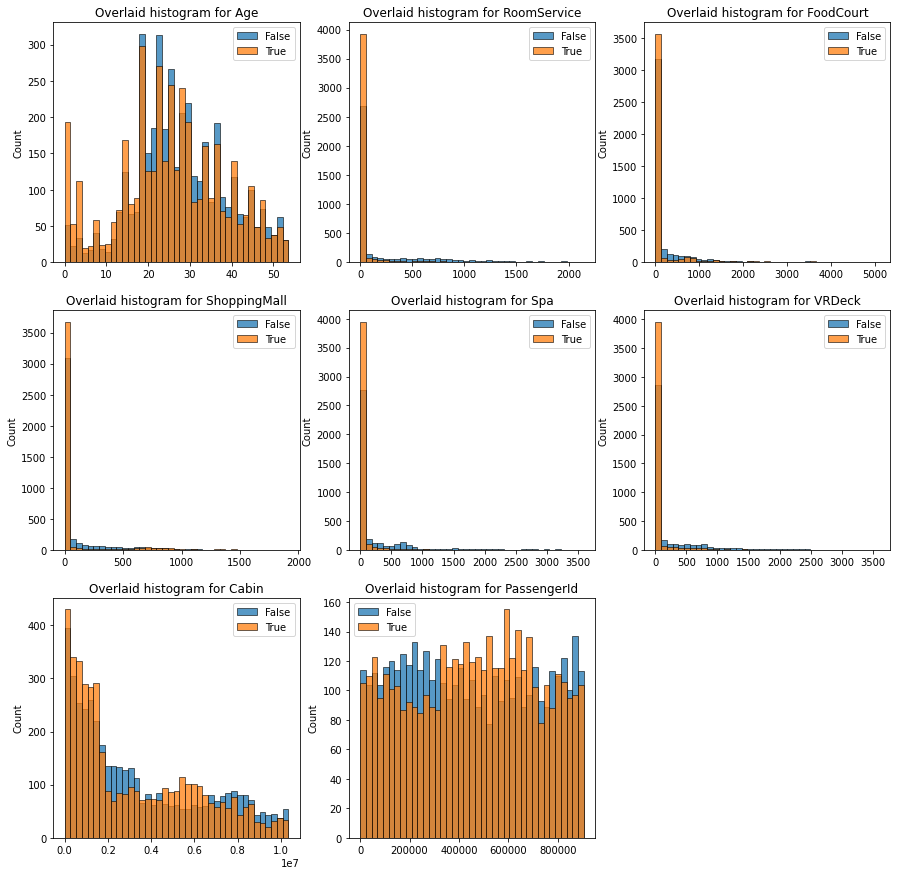

Latency (hh:mm:ss.ms): 0:00:06.284270
Features mapped: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin', 'PassengerId']


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
"""
Will generate a report with 3 columns, and as many rows as there are features
to fill those columns representing the data in comparison to the label data.

The goal of this function is to help visualize the data. 
"""
def continuous_shape_report(self, plt=plt, dt=dt, sns=sns, np=np):
  continuous_features, data_clean, label, labels_unique = \
    self._attr('continuous_features', 'data_clean', 'label', 'labels_unique')
  num_rows = len(continuous_features) // 3 + (len(continuous_features) % 3 > 0)
  fig,axes = plt.subplots(num_rows,3, figsize=(15,5 * num_rows))
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colors = prop_cycle.by_key()['color']
  colors_len = len(colors)
  row_i, col_i = 0, 0
  start_ = dt.now()
  for feature in continuous_features:
    column_ = "%s_clean" % feature
    bars = [data_clean[data_clean[label] == _label][column_] 
                 for _label in labels_unique]
    xmin = min([_bar.min() for _bar in bars])
    xmax = max([_bar.max() for _bar in bars])
    width = (xmax - xmin) / 40
    ax = axes[row_i,col_i]
    for _i, _bar in enumerate(bars):
      sns.histplot(list(_bar), color=colors[_i % len(colors)],bins=np.arange(xmin,xmax,width), ax=ax)
    ax.legend(labels_unique)
    ax.title.set_text('Overlaid histogram for {}'.format(feature))
    col_i = (col_i + 1) % 3
    row_i = row_i + 1 if col_i % 3 == 0 else row_i
  # Clean up any empty columns
  while not col_i % 3 == 0:
    axes[row_i,col_i].set_axis_off()
    col_i += 1
  #plt.tight_layout()
  plt.show()
  # Tracking latency since it's a bit of long running function.
  print("Latency (hh:mm:ss.ms): {}".format(dt.now() - start_))
  print("Features mapped: {}".format(continuous_features))
Augury.constructor()(continuous_shape_report)
"""
"""
augur.continuous_shape_report()

Based on the above plots - we may need to transform some of them so that they appear more Gaussian in Distribution.

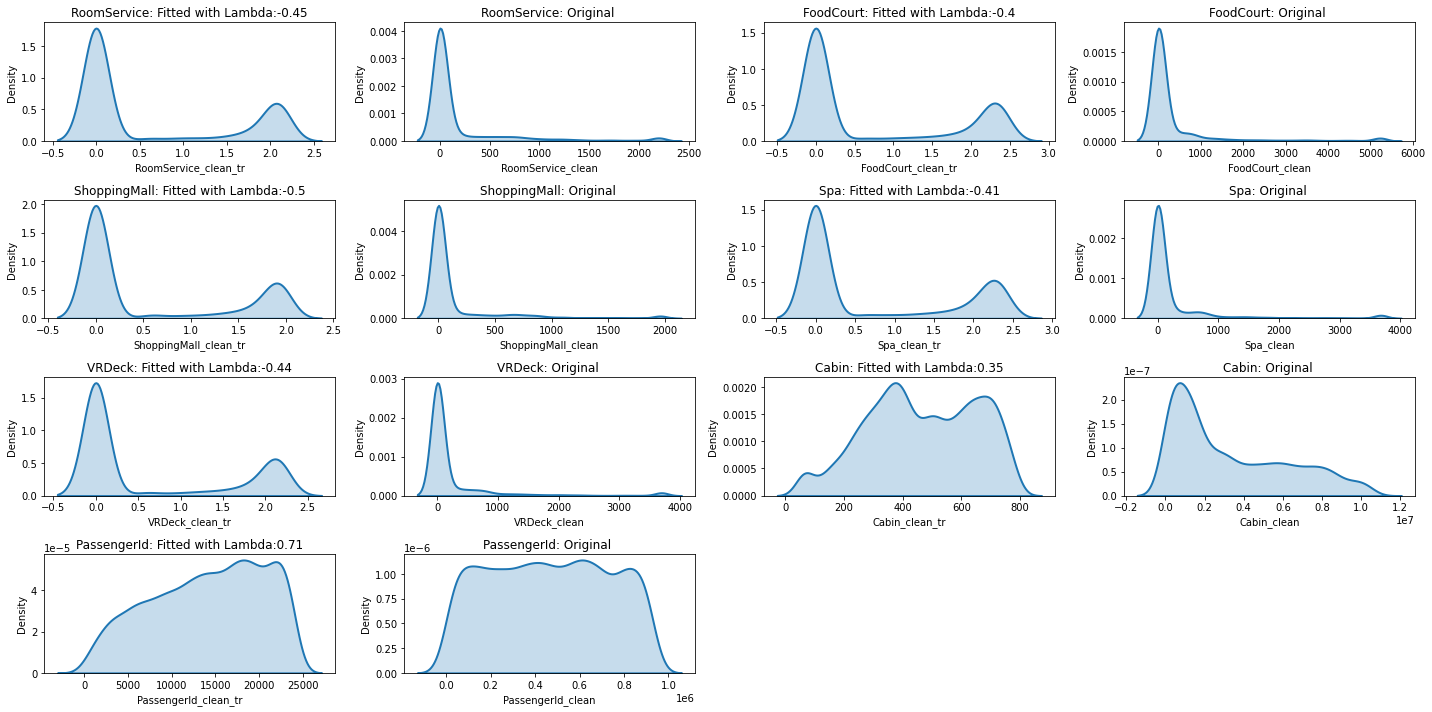

Latency (hh:mm:ss.ms):0:00:07.712946


In [25]:
from scipy.stats import boxcox
### BoxCox Plots
# For the specific examples from `titanic-spaceship` we can see that Age is normally distributed
# so no transformations will be required there - however the other features which
# relate to purchases seem to have more of a poisson type curve, where there
# are a lot of individuals who did not make any purchases, as such it might be
# beneficial to transform these to more normal looking shapes.
CONTINUOUS_FEATURES_BOXCOXPLOTS = {
    "columns": ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Cabin", "PassengerId"],
}
"""
Plot Box Cox transformations, adds "_tr" columns to the data_clean attribute, 
and records the lambda used in the "_stats" attr.
"""
def __call_boxcox(self, lmbda=None, boxcox=boxcox, *, data, column):
  c = data[column].min() + 1
  data_ = data[column] + c
  return boxcox(data_) if lmbda is None else boxcox(data_, lmbda)  
def __box_cox_plots(self, *features, plt=plt, dt=dt, sns=sns):
  data_clean, = self._attr('data_clean')
  _rows = len(features) // 2 + (len(features) % 2 > 0)
  fig,axes = plt.subplots(_rows, 4, figsize=(5 * _rows, 10))
  row_i, col_i = 0, 0
  start_ = dt.now()
  transformations = []
  for feature in features:
    column_ = "%s_clean" % feature
    column_tr = "%s_tr" % column_
    data_clean[column_tr], fitted_lambda = self.__call_boxcox(data=data_clean, 
                                                              column=column_)
    # Save Lambda
    transformations.append((feature, fitted_lambda))
    ax = axes[row_i, col_i]
    ax.title.set_text("{}: Fitted with Lambda:{}".format(feature, round(fitted_lambda,2)))
    axes[row_i, col_i + 1].title.set_text(
        "{}: Original ".format(feature))
    sns.kdeplot(data_clean[column_], fill=True, linewidth=2, ax = axes[row_i, col_i + 1])
    sns.kdeplot(data_clean[column_tr], fill=True, linewidth=2, ax = ax)
    col_i = (col_i + 2) % 4
    row_i = row_i + 1 if col_i % 4 == 0 else row_i
  self._attr(boxcox_pipeline=transformations)
  while(col_i % 4 > 0):
    axes[row_i,col_i].set_axis_off()
    col_i +=1
  plt.tight_layout()
  plt.show()
  print("Latency (hh:mm:ss.ms):{}".format(dt.now() - start_))

def box_cox_plots(self, columns=[]):
  data_raw, = self._attr('data_raw')
  assert set(columns) and set(columns).issubset(data_raw.columns), \
          "Columns: {}, do not exists in: {}".format(columns, data_raw.columns)
  self.__box_cox_plots(*columns)
Augury.constructor()(box_cox_plots, __box_cox_plots, __call_boxcox)
"""
"""
augur.box_cox_plots(**CONTINUOUS_FEATURES_BOXCOXPLOTS)

#### Transform to Numerical Indicators

In [26]:
from sklearn.preprocessing import OrdinalEncoder
from pandas.api.types import is_numeric_dtype

"""
Checks data for non-numeric values and converts to integers.
"""
def numeric_transformation(self, test_data=None, is_numeric_dtype=is_numeric_dtype,
                           OrdinalEncoder=OrdinalEncoder):
  _target, = self._attr('data_clean') if test_data==None else test_data
  for column in _target.columns:
    if is_numeric_dtype(_target[column]):
      continue
    if column.endswith("_tr"):
      continue
    enc = OrdinalEncoder()
    # Save Encoder (needed for test)
    stats_attr = "%s_stats" % column
    stats_,  = self._attr(overwrite=False, **{stats_attr: {}})
    if test_data == None:
      # Reshaping so that we can encode one column at a time
      try:
        stats_['enc'] = enc.fit(_target[[column]].values.reshape(-1,1))
      except:
        # Most likely getting an error for booleans where added a 3rd cat.
        # for handling NaNs
        stats_['enc'] = enc.fit(_target[[column]].astype(str).values.reshape(-1,1))
      self._attr(**{stats_attr:stats_})
    try:
      _target["%s_tr" % column] = stats_['enc'].transform(
          _target[column].values.reshape(-1,1))
    except:
      # Typically thrown due to bool mixed with str... so casting
      _target["%s_tr" % column] = stats_['enc'].transform(
          _target[column].astype(str).values.reshape(-1,1))
Augury.constructor()(numeric_transformation)
"""
"""
augur.numeric_transformation()
augur.data_clean.head()

,Transported,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,...,FoodCourt_clean_tr,ShoppingMall_clean_tr,Spa_clean_tr,VRDeck_clean_tr,Cabin_clean_tr,PassengerId_clean_tr,HomePlanet_clean_tr,CryoSleep_clean_tr,Destination_clean_tr,VIP_clean_tr
0,False,39.0,0.0,0.0,0.0,0.000000,0.0,Europa,False,TRAPPIST-1e,...,0.000000,0.000000,0.000000,0.000000,66.093948,59.618653,1.0,0.0,3.0,0.0
1,True,24.0,109.0,9.0,25.0,549.000000,44.0,Earth,False,TRAPPIST-1e,...,1.502729,1.616524,2.273000,1.846575,67.403070,79.663605,0.0,0.0,3.0,0.0
2,False,55.0,43.0,3576.0,0.0,3681.082317,49.0,Europa,False,TRAPPIST-1e,...,2.398135,0.000000,2.375229,1.865849,66.381979,97.835399,1.0,0.0,3.0,2.0
3,False,33.0,0.0,1283.0,371.0,3329.000000,193.0,Europa,False,TRAPPIST-1e,...,2.350642,1.910703,2.371571,2.048329,66.381979,98.009964,1.0,0.0,3.0,0.0
4,True,16.0,303.0,70.0,151.0,565.000000,2.0,Earth,False,TRAPPIST-1e,...,2.041276,1.850727,2.275200,0.871088,79.456229,114.726958,0.0,0.0,3.0,0.0


## Feature Scaling & Optimal Count

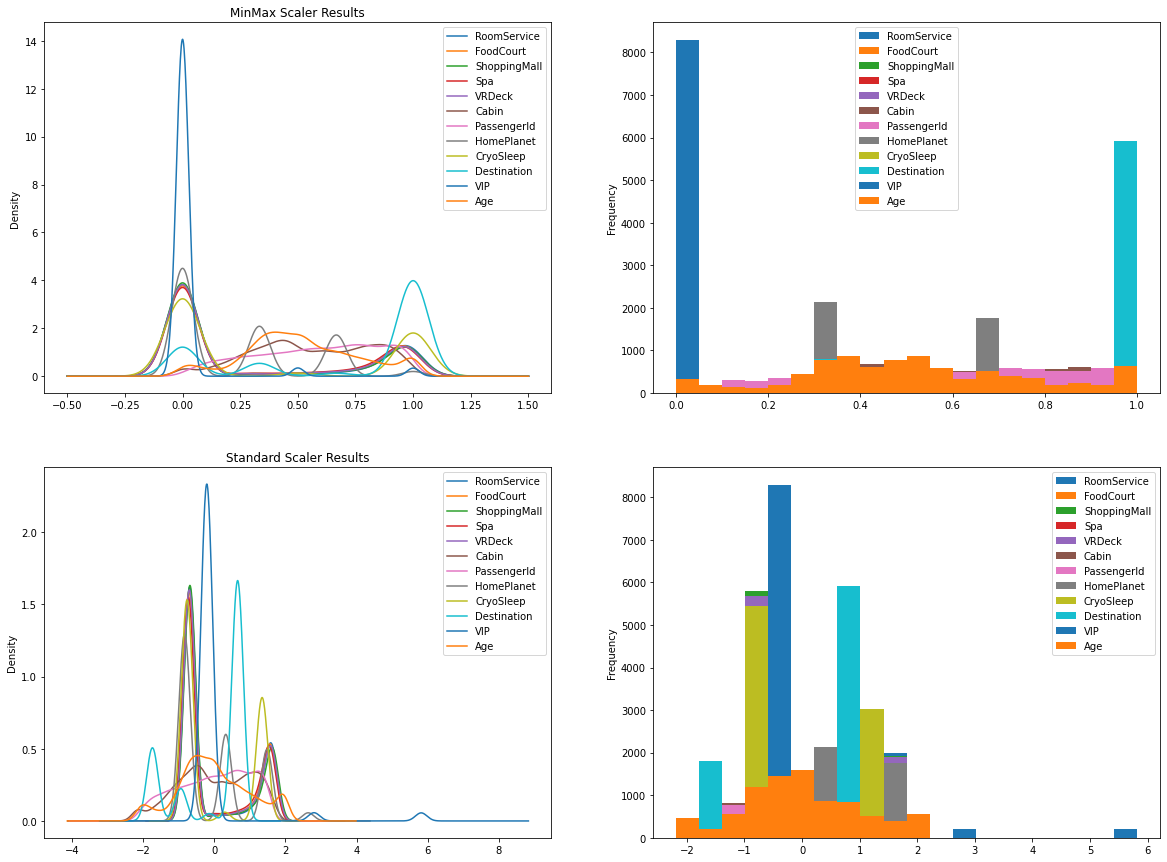

Latency (hh:mm:ss.ms):0:00:14.112006


In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
"""
Displays Graphs for Comparing MinMax vs Standard.
"""
def set_data_final(self, test=False):
  data_clean, label, data_test_clean = self._attr('data_clean', 'label', 'data_test_clean')
  data_final, data_test_final, = self._attr(
                  overwrite=False, data_final=pd.DataFrame(data_clean[label]), 
                  data_test_final=pd.DataFrame())  
  _target, _ref = (data_final, data_clean) if test == False else \
    (data_test_final, data_test_clean)
  columns_priority = [_c for _c in data_clean.columns if _c.endswith("_tr")]
  columns_processed = {}
  for column_ in columns_priority:
    column = column_.split("_")[0]
    _target[column] = _ref[column_]
    columns_processed[column] = 1
  for column_ in _ref.columns:
    column = column_.split("_")[0]
    if column in columns_processed:
      continue
    _target[column] = _ref[column_]
def scaler_report(self, dt=dt, plt=plt,MinMaxScaler=MinMaxScaler, 
                  StandardScaler=StandardScaler, pd=pd):
  data_final, label = self._attr('data_final','label')
  fig,axes = plt.subplots(2, 2, figsize=(20, 15))
  row_i, col_i = 0, 0
  start_ = dt.now()
  features_ = data_final.drop([label], axis=1)
  # MinMax
  minmax_scaler, standard_scaler = self._attr(minmax_scaler=MinMaxScaler().fit(features_), 
                                              standard_scaler=StandardScaler().fit(features_))
  _minmax_data, _standard_data = \
  self._attr(data_minmax_scaled=pd.DataFrame(minmax_scaler.transform(features_), 
                                   index=features_.index, columns=features_.columns),
             data_standard_scaled=pd.DataFrame(standard_scaler.transform(features_),
                                   index=features_.index, columns=features_.columns))
  axes[row_i, col_i].title.set_text("MinMax Scaler Results")
  for _data in [_minmax_data, _standard_data]:
    _data.plot(kind='kde', ax=axes[row_i,col_i])
    _data.plot(kind='hist', bins=20, ax=axes[row_i,col_i + 1])
    row_i += 1
  axes[row_i - 1, col_i].title.set_text("Standard Scaler Results")
  plt.show()
  print("Latency (hh:mm:ss.ms):{}".format(dt.now() - start_))
Augury.constructor()(scaler_report, set_data_final)
"""
"""
augur.set_data_final()
augur.scaler_report()

In [28]:
# Based on the above graphs, and knowing that the data generally isn't normally
# distributed - will set the scaler to be MinMax
SCALAR_CONFIG = {
    'scaler' : 'minmax' # minmax | standard
}
"""
Sets the scaler to be used on test.
"""
def set_scaler(self, scaler='minmax'):
  valid_scalers = ['minmax', 'standard']
  assert scaler in valid_scalers, "Expecting 'scaler' to be one of %s" % valid_scalers
  scaler_, data_ = self._attr("%s_scaler" % scaler, "data_%s_scaled" % scaler)
  self._attr(scaler=scaler_, data_scaled=data_)
Augury.constructor()(set_scaler)
"""
"""
augur.set_scaler()
augur.data_scaled.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Age
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003833,0.000000,0.333333,0.0,1.0,0.0,0.709091
1,0.908478,0.623182,0.820133,0.956960,0.835242,0.005654,0.000836,0.000000,0.0,1.0,0.0,0.436364
2,0.845200,0.994508,0.000000,1.000000,0.843960,0.004234,0.001594,0.333333,0.0,1.0,1.0,1.000000
3,0.000000,0.974812,0.969383,0.998460,0.926499,0.004234,0.001601,0.333333,0.0,1.0,0.0,0.600000
4,0.953915,0.846518,0.938955,0.957886,0.394010,0.022422,0.002298,0.000000,0.0,1.0,0.0,0.290909


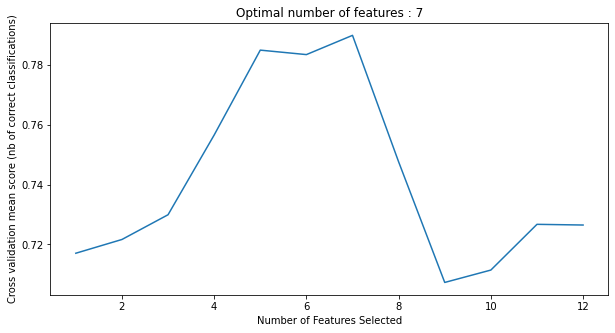

Latency (hh:mm:ss.ms): 0:00:35.080562
Features passed to compressed data set:
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
HomePlanet
CryoSleep


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0
1,0.908478,0.623182,0.820133,0.956960,0.835242,0.000000,0.0
2,0.845200,0.994508,0.000000,1.000000,0.843960,0.333333,0.0
3,0.000000,0.974812,0.969383,0.998460,0.926499,0.333333,0.0
4,0.953915,0.846518,0.938955,0.957886,0.394010,0.000000,0.0


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import joblib
### Feature Analysis using RFECV

"""
Report which helps identify key features.
Could be used to optimize model training.
"""
def __set_and_fit_rfecv(self, RFECV=RFECV, *, estimator, X, y):
  _rfecv = RFECV(estimator=estimator)
  _rfecv.fit(X, y)
  return _rfecv
def feature_analysis(self, max_depth=None, memory=joblib.Memory(AUGURY_CACHE, verbose=0),
                     RandomForestClassifier=RandomForestClassifier):
  max_depth = len(self.data_scaled.columns) // 2 if max_depth is None else max_depth
  data_scaled, data_final, label = self._attr('data_scaled', 'data_final', 'label')
  rf = RandomForestClassifier(max_depth=max_depth)
  start_ = dt.now()
  cache_rfecv = memory.cache(self.__set_and_fit_rfecv, ignore=['self', 'RFECV'])
  rfecv = cache_rfecv(RFECV=RFECV, estimator=rf, X=data_scaled, y=data_final[label])
  setattr(self, "rfecv", rfecv) # setting attr for debug
  time_taken = dt.now() - start_
  # Plot number of features VS. cross-validation scores
  plt.figure(figsize=(10,5))
  plt.xlabel("Number of Features Selected")
  plt.ylabel("Cross validation mean score (nb of correct classifications)")
  plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
  plt.title("Optimal number of features : %d" % rfecv.n_features_)
  plt.show()
  print("Latency (hh:mm:ss.ms): {}".format(time_taken))
  features_compressed = []
  print("Features passed to compressed data set:")
  for _i, _f in enumerate(rfecv.ranking_):
    if _f == 1:
      feature_ = rfecv.feature_names_in_[_i]
      features_compressed.append(feature_)
      print(feature_)
  self._attr(data_compressed=data_scaled[features_compressed])
Augury.constructor()(feature_analysis, __set_and_fit_rfecv)
"""
"""
augur.feature_analysis()
augur.data_compressed.head()

## Train / Validation Split

In [30]:
from sklearn.model_selection import train_test_split
"""
"""
def confirm_splits(self):
  # Confirm split
  for _dataset in ["y", "y_compressed"]:
    for _split in ["%s_train" % _dataset, "%s_val" % _dataset]:
      print("%s as %% of rows" % _split)
      print(round(len(getattr(self, _split)) / self.data_final[self.label].shape[0], 2))
def split_hash(self, prefix="",*, X, y):
  split_tuple = train_test_split(X, y, test_size=0.2)
  return {
    'X_%strain' % prefix  : split_tuple[0], 
    'X_%sval' % prefix    : split_tuple[1], 
    'y_%strain' % prefix  : split_tuple[2], 
    'y_%sval' % prefix    : split_tuple[3]    
  }
def set_train_val_data(self, train_test_split=train_test_split):
  data_final, data_scaled, data_compressed, label = self._attr('data_final', 'data_scaled', 'data_compressed', 'label')
  labels_ = data_final[label]
  features_, features_compressed = data_scaled, data_compressed 
  _split_dict = {
    **self.split_hash(X=features_, y=labels_),
    **self.split_hash(prefix="compressed_", X=features_compressed, y=labels_),   
  }
  self._attr(**_split_dict)
Augury.constructor()(set_train_val_data, confirm_splits, split_hash)
"""
"""
augur.set_train_val_data()
augur.confirm_splits()

y_train as % of rows
0.8
y_val as % of rows
0.2
y_compressed_train as % of rows
0.8
y_compressed_val as % of rows
0.2


## Principal Component Analysis

In [31]:
from sklearn.decomposition import PCA
# Perform with data_scaled and continuous features - fed to KMeans
"""
"""
def get_continuous_data(self, X, np=np, dt=dt):
  continuous_features, = self._attr('continuous_features')
  _columns = np.intersect1d(continuous_features, X.columns)
  return (X[_columns], _columns)
def pca_analysis(self, PCA=PCA):
  X_train, data_scaled, y_train, X_val, y_val = \
    self._attr('X_train', 'data_scaled', 'y_train', 'X_val', 'y_val')
  X_continuous_train, _ = self.get_continuous_data(X_train)
  _explained_variance_ratio, _attempts = 0, 0
  while(_explained_variance_ratio < 0.80 and _attempts < len(data_scaled.columns)):
    pca=PCA(n_components=(_attempts+2))
    pca.fit(X_continuous_train)
    _explained_variance_ratio = sum(pca.explained_variance_ratio_)
    _attempts += 1
  start_ = dt.now()
  self._attr(X_pca_train=pca.transform(X_continuous_train), y_pca_train=y_train)
  X_continuous_val, _ = self.get_continuous_data(X_val)
  self._attr(X_pca_val=pca.transform(X_continuous_val), y_pca_val=y_val)
  print("Latency (hh:mm:ss:ms):{}".format(dt.now() - start_))
  print("PCA Analysis set {} components. With Total Explained Variance Ratio: {}%".format(
      _attempts + 1, round(_explained_variance_ratio * 100,2)))
Augury.constructor()(pca_analysis, get_continuous_data)
"""
"""
augur.pca_analysis()

Latency (hh:mm:ss:ms):0:00:00.007008
PCA Analysis set 5 components. With Total Explained Variance Ratio: 84.46%


### KMeans Benchmark

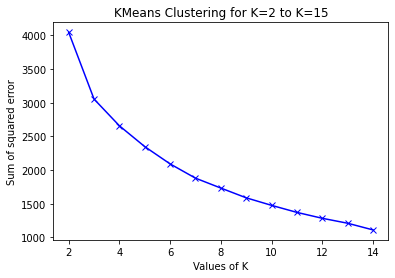

Latency (hh:mm:ss.ms):0:00:10.068225


In [32]:
from sklearn.cluster import KMeans
# Trying to increase my knowledge of clustering so adding here since it's
# handled differently than the other models which will be presented.

"""
Generates an Elbow Report for KMeans Analysis
"""
def kmeans_elbow_report(self, dt=dt, plt=plt):
  X_pca_train, = self._attr('X_pca_train')
  Sum_of_squared_distances = []
  K = range(2,15)
  start_ = dt.now()
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_pca_train)
    Sum_of_squared_distances.append(kmeans.inertia_)
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared error') 
  plt.title('KMeans Clustering for K=2 to K=15')
  plt.show()
  print("Latency (hh:mm:ss.ms):{}".format(dt.now() - start_))
Augury.constructor()(kmeans_elbow_report)
"""
"""
augur.kmeans_elbow_report()

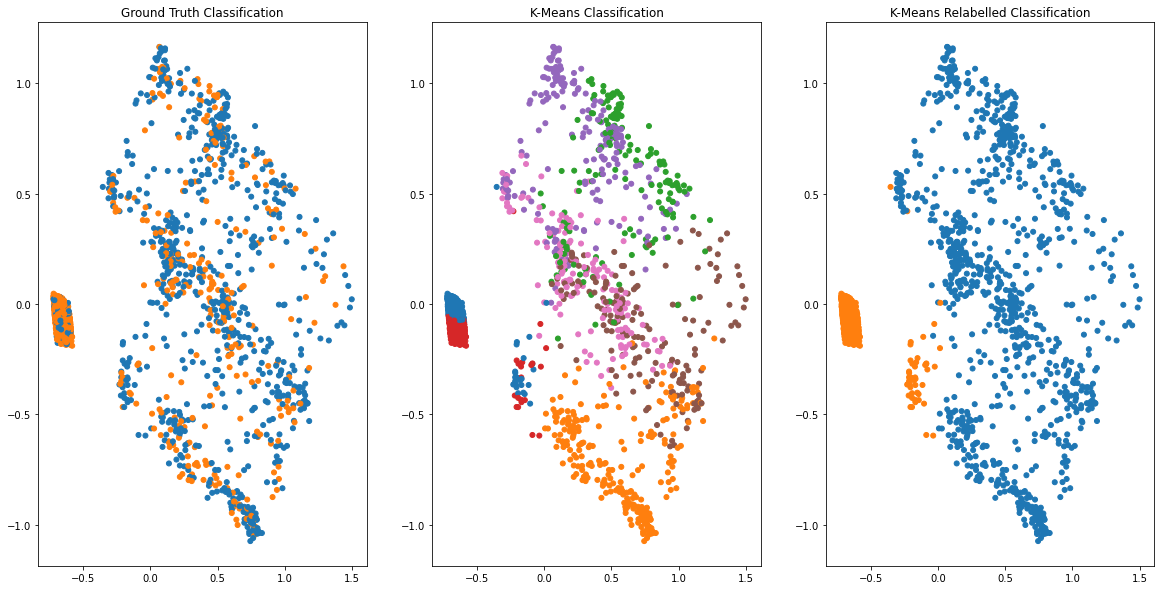

Latency (hh:mm:ss.ms):0:00:00.124771
kmeans Performance -- Accuracy: 72.63% / Precision: 73.04% / Recall: 72.63% / Latency (hh:mm:ss.ms): 0:00:00.124771


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import contingency_matrix
# Not much of an elbow - let's try 7 I guess.
# TODO: Am I doing this right? This doesn't give great results...
KMEANS_ANALYSIS_CONFIG = {
    'n_clusters' : 7
}
"""
Generates a Cluster Report based on PCA-1 and PCA-2
Relabels according to label based on a contingency matrix, whic is used
for traditional accuracy, precision, recal, reporting.
"""
def print_performance(self, *, model, accuracy, precision, recall, latency):
  (accuracy, precision, recall) = (round(accuracy * 100, 2), round(precision * 100, 2), round(recall * 100, 2))
  print("{} Performance -- Accuracy: {}% / Precision: {}% / Recall: {}% / Latency (hh:mm:ss.ms): {}".format(
      model, accuracy, precision, recall, latency
  ))
def set_performance(self, *, model, accuracy, precision, recall, latency, 
                    output_string=False):
  models, best_accuracy, best_precision, best_recall, best_latency = self._attr(
      overwrite=False, models={}, best_accuracy=("",0), best_precision=("",0),
      best_recall=("",0), best_latency=("",0)
  )
  _t = { 'accracy' : accuracy, 'precision': precision, 'recall' : recall, 
        'latency': latency } 
  models[model] = {**_t, **models[model]} if model in models else _t
  self._attr(models=models)
  for _top in ['accuracy', "precision", 'recall']:
    _best = "best_%s" % _top
    if locals()[_top] > locals()[_best][1]:
      self._attr(**{_best:(model,locals()[_top])})
  if not best_latency[1] or latency < best_latency[1]:
    self._attr(best_latency=(model, latency))
  if output_string:
    self.print_performance(model=model, accuracy=accuracy,
                      precision=precision, recall=recall, latency=latency)
def kmeans_plot_axes(self, *, axes, x, y, c, title, plt=plt, np=np):
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colors = prop_cycle.by_key()['color']
  colors_len = len(colors)
  color_theme = np.array(colors)

  axes.scatter(x=x, y=y, c=color_theme[c % colors_len], s=25)
  axes.title.set_text(title)
def kmeans_results(self, classification_report=classification_report, *, relabel,
                   time_taken):
  y_pca_val, = self._attr('y_pca_val')
  kmeans_results = classification_report(y_pca_val, relabel, output_dict=True, 
                                         zero_division=0)
  self.set_performance(model='kmeans', accuracy=kmeans_results['accuracy'],
                       precision=kmeans_results['weighted avg']['precision'], 
                       recall=kmeans_results['weighted avg']['recall'],
                       latency=time_taken, output_string=True)
def kmeans_analysis(self, n_clusters=2, plt=plt, KMeans=KMeans, dt=dt, np=np, 
                    contingency_matrix=contingency_matrix):
  X_pca_val, y_pca_val = self._attr('X_pca_val', 'y_pca_val')
  fig,axes = plt.subplots(1,3, figsize=(20,10))

  clustering = KMeans(n_clusters=n_clusters)
  start_ = dt.now()
  clustering.fit(X_pca_val)
  time_taken = dt.now() - start_

  self.kmeans_plot_axes(axes=axes[0], x=X_pca_val[:,0], y=X_pca_val[:,1], 
                    c=y_pca_val, title='Ground Truth Classification')
  self.kmeans_plot_axes(axes=axes[1], x=X_pca_val[:,0], y=X_pca_val[:,1], 
                    c=clustering.labels_, title='K-Means Classification')

  _n = contingency_matrix(y_pca_val, clustering.labels_)
  choose_arr = _n.argmax(axis=0)
  relabel = np.choose(clustering.labels_, choose_arr).astype(np.int64)

  self.kmeans_plot_axes(axes=axes[2], x=X_pca_val[:,0], y=X_pca_val[:,1], 
                    c=relabel, title='K-Means Relabelled Classification')  
  plt.show()
  print("Latency (hh:mm:ss.ms):{}".format(time_taken))
  self.kmeans_results(relabel=relabel, time_taken=time_taken)
Augury.constructor()(kmeans_analysis,set_performance,kmeans_results, kmeans_plot_axes, print_performance)
"""
"""
augur.kmeans_analysis(**KMEANS_ANALYSIS_CONFIG)

## Model Selection
|                          | Label Type | Training Speed | Performance Speed | Simplicity | Performance | Performance With Limited Data |
|:------------------------:|:----------:|:--------------:|:-----------------:|:----------:|:-----------:|:-----------------------------:|
|    logistic-regression   |    class   |      high      |        high       |     med    |     low     |              high             |
| support-vector-machines  |    class   |       low      |        med        |     low    |     med     |              high             |
|   multilayer-perceptron  |    both    |       low      |        med        |     low    |     high    |              low              |
|       random-forest      |    both    |       med      |        med        |     low    |     med     |              low              |
|       boosted-trees      |    both    |       low      |        high       |     low    |     high    |              low              |

### Hyperparameter Tuning

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings as warnings
# KMeans couldn't produce obvious cluster, so will try some other models.
# Going to focus on performance so will select SVM, multilater-perceptron, and boosted tree to compare.
"""
"""
def prep_tuning(self, clear_cache=False, ConvergenceWarning=ConvergenceWarning,
                warnings=warnings, memory=joblib.Memory(AUGURY_CACHE, verbose=0)):
  # Removing ConvergenceWarning from cells to keep cell results clean.
  warnings.simplefilter('ignore', category=ConvergenceWarning)
  if clear_cache:
    memory.clear(warn=False)
def __call_fit(self, cv, X, y):
  return cv.fit(X, y.values.ravel())
def feature_importance_report(self,model, X, np=np, plt=plt):
  if not 'feature_importances_' in dir(model.best_estimator_):
    return
  feat_imp = model.best_estimator_.feature_importances_
  indices = np.argsort(feat_imp)
  plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
  plt.barh(range(len(indices)), feat_imp[indices], align='center')
  plt.show()
def save_tuning_results(self, *, name, model):
  models, = self._attr('models')
  if not name in models:
    models[name] = {}
  models[name]['model'] = model
  self._attr(models=models)
def hypertune_models(self, models, data=None, GridSearchCV=GridSearchCV, dt=dt,
                     memory=joblib.Memory(AUGURY_CACHE, verbose=0),**kwargs):
  assert len(models) <= 3, "Max 3 Models allowed for Hyper Parameter Tuning"
  self.prep_tuning(**kwargs)
  models_, = self._attr('models')
  for _m in models:
    valid_keys = ['name', 'model', 'parameters']
    _vals = self._hash(_m, *valid_keys)
    for _i, _val in enumerate(_vals):
      assert not _val is None, "Missing {} key".format(valid_keys[_i])
    
    X, y = self._attr('X_train', 'y_train') if data==None else data
    name, model, parameters = _vals
    GridSearchCV = memory.cache(GridSearchCV)
    cv = GridSearchCV(model, parameters, cv=5)
    print('{} ...GridSearchCV (this may take a while)\n======='.format(name.capitalize()))
    start_ = dt.now()
    call_fit = memory.cache(self.__call_fit, ignore=['self'])
    model_ = call_fit(cv, X, y)
    print('Latency (hh:mm:ss.ms):{}'.format(dt.now() - start_))
    print('Score (Mean Cross Validated): {}% | BEST PARAMS: {}\n'.format(
        round(model_.best_score_ * 100, 2), model_.best_params_))
    self.feature_importance_report(model_, X)
    self.save_tuning_results(name=name, model=model_)
Augury.constructor()(prep_tuning,__call_fit,feature_importance_report, hypertune_models, save_tuning_results)
"""
"""

'\n'

Logisticregression ...GridSearchCV (this may take a while)
Latency (hh:mm:ss.ms):0:00:01.614891
Score (Mean Cross Validated): 74.48% | BEST PARAMS: {'C': 0.1}

Supportvectormachines ...GridSearchCV (this may take a while)
Latency (hh:mm:ss.ms):0:00:52.960786
Score (Mean Cross Validated): 76.34% | BEST PARAMS: {'C': 10, 'kernel': 'rbf'}

Gradientboosting ...GridSearchCV (this may take a while)
Latency (hh:mm:ss.ms):0:07:07.737313
Score (Mean Cross Validated): 79.72% | BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}



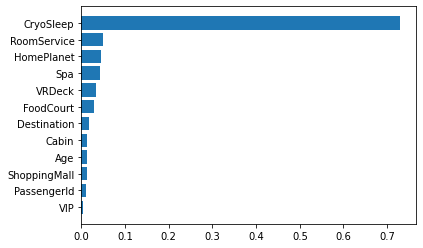

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
"""
Default Configs listed below
"""
## Note Regression has not been tested.
class_ = augur.label_type == 'categorical'
##
LogisticRegressionConfig = {
  'name'      : 'LogisticRegression',
  'model'     : LogisticRegression(),
  'parameters': {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
  }
} if class_ else None
SupportVectorMachinesConfig = {
  'name'      : 'SupportVectorMachines',
  'model'     : SVC(),
  'parameters': {
    'kernel': ['linear', 'rbf'],
    'C'     : [0.1, 1, 10]
  },
} if class_ else None
MultilaterPerceptronConfig = {
  'name'      : 'MultilaterPerceptron',
  'model'     : MLPClassifier() if class_ else MLPRegressor(),
  'parameters': {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation'        : ['relu', 'tanh', 'logistic'],
    'learning_rate'     : ['constant', 'invscaling', 'adaptive']
  }
}
RandomForestConfig = {
  'name'      : 'RandomForest',
  'model'     : RandomForestClassifier() if class_ else RandomForestRegressor(),
  'parameters': {
    'n_estimators'  : [5, 50, 250, 500],
    'max_depth'     : [1, 3, 5, 7, 9],
    'learning_rate' : [0.01, 0.1, 1, 10, 100]
  }
}
GradientBoostingConfig = {
  'name'      : 'GradientBoosting',
  'model'     : XGBClassifier() if class_ else XGBRegressor(),
  'parameters': {
    'n_estimators'  : [5, 50, 250, 500],
    'max_depth'     : [1, 3, 5, 7, 9],
    'learning_rate' : [0.01, 0.1, 1, 10, 100]
  }
}
"""
"""
MODEL_CONFIGS = [
          LogisticRegressionConfig,
          SupportVectorMachinesConfig,
          #MultilaterPerceptronConfig, 
          #RandomForestConfig, 
          GradientBoostingConfig           
]
augur.hypertune_models(MODEL_CONFIGS)

### Fit

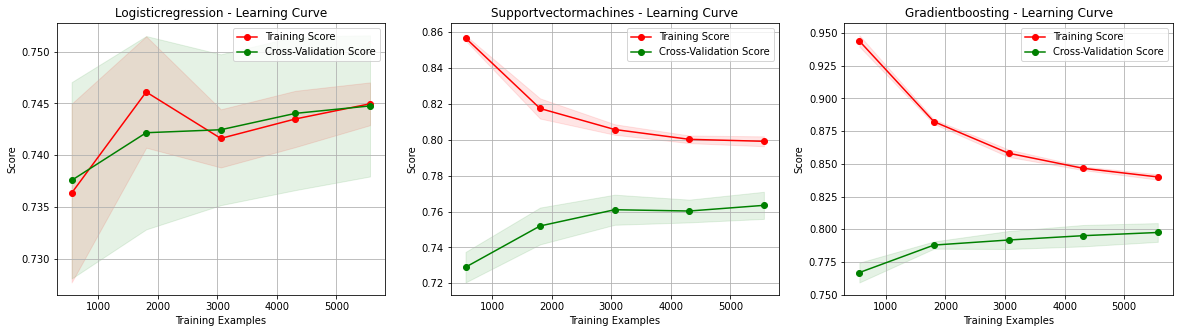

Latency (hh:mm:ss.ms):0:00:49.087186


In [36]:
from sklearn.model_selection import learning_curve
"""
"""
def plot_learning_curve(self, models, plt=plt, dt=dt, learning_curve=learning_curve,
                        memory=joblib.Memory(AUGURY_CACHE, verbose=0), np=np):
  """
  Modified to display two Learning Curve graphs for side-by-side comparison,
  from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
  """
  models_, = self._attr('models')
  _, axes = plt.subplots(1,3, figsize=(20,5))

  start_ = dt.now()
  idx = 0;
  for model in models:
    name = (lambda name, **_: name)(**model)
    axes[idx].set_title("%s - Learning Curve" % name.capitalize())
    axes[idx].set_xlabel("Training Examples")
    axes[idx].set_ylabel("Score")
    learning_curve = memory.cache(learning_curve)
    train_sizes, train_scores, test_scores = learning_curve(
        models_[name]['model'].best_estimator_,
        self.X_train,
        self.y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes[idx].grid()
    axes[idx].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color='r',
    )
    axes[idx].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color='g',
    )
    axes[idx].plot(
        train_sizes, train_scores_mean, "o-", color='r', label='Training Score'
    )
    axes[idx].plot(
        train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score'
    )
    axes[idx].legend(loc="best")
    idx += 1
  plt.show()
  print("Latency (hh:mm:ss.ms):{}".format(dt.now() - start_))
Augury.constructor()(plot_learning_curve)
"""
"""
augur.plot_learning_curve(MODEL_CONFIGS)

### Evaluation

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
"""
"""
def evaluate_model(self, *, name, model, features, labels, dt=dt, average='binary',
                   accuracy_score=accuracy_score, precision_score=precision_score,
                   recall_score=recall_score):
    start_ = dt.now()
    pred = model.predict(features)
    end_ = dt.now()
    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred, average=average)
    recall = recall_score(labels, pred, average=average)
    self.set_performance(model=name, accuracy=accuracy, precision=precision,
                           recall=recall, latency=end_-start_, output_string=True)
    
def evaluate_models(self, model_configs, memory=joblib.Memory(AUGURY_CACHE, verbose=0), 
                    **kwargs):
  models, X_train, y_train = self._attr('models', 'X_train', 'y_train')
  for model in model_configs:
    name = (lambda name, **_: name)(**model)
    evaluate_model = memory.cache(self.evaluate_model, ignore=['self'])
    self.evaluate_model(name=name, model=models[name]['model'].best_estimator_, 
                        features=X_train, labels=y_train, **kwargs)
Augury.constructor()(evaluate_models, evaluate_model)
"""
"""
augur.evaluate_models(MODEL_CONFIGS)

LogisticRegression Performance -- Accuracy: 74.55% / Precision: 76.78% / Recall: 70.71% / Latency (hh:mm:ss.ms): 0:00:00.002240
SupportVectorMachines Performance -- Accuracy: 79.54% / Precision: 79.37% / Recall: 80.07% / Latency (hh:mm:ss.ms): 0:00:01.801583
GradientBoosting Performance -- Accuracy: 83.32% / Precision: 82.21% / Recall: 85.23% / Latency (hh:mm:ss.ms): 0:00:00.051801


In [38]:
"""
"""
def set_evalutation_criteria(self, *, criteria):
  _valid = ['accuracy', 'precision', 'recall']
  assert criteria in _valid, "Invalid criteria, expecting one of {}.".format(_valid)
  self._attr(evaluation_criteria=criteria)
Augury.constructor()(set_evalutation_criteria)
"""
"""
augur.set_evalutation_criteria(criteria='accuracy')
augur.evaluation_criteria

'accuracy'

### Tune
Will compare against compressed dataset.

In [39]:
"""
#TODO
def tune(self):
  evaluation_criteria = getattr(self, 'evaluation_criteria')
  model_name = getattr(self, "best_%s" % evaluation_criteria)[0]
  # Todo - need to refactor some of the above to be a bit less encompassing
for _func in [tune]:
  constructor_(Augury)(_func)

"""

'\n#TODO\ndef tune(self):\n  evaluation_criteria = getattr(self, \'evaluation_criteria\')\n  model_name = getattr(self, "best_%s" % evaluation_criteria)[0]\n  # Todo - need to refactor some of the above to be a bit less encompassing\nfor _func in [tune]:\n  constructor_(Augury)(_func)\n\n'

## Test
Read in File
Apply same transformation as training, and predict with best model.

In [40]:
testing_data = pd.read_csv(TEST_PATH)
testing_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [41]:
augur.set_data_from_path(data_test=TEST_PATH)
augur.data_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [42]:
augur.process_nulls(test_data=(augur.data_test_clean, augur.data_test))
augur.data_test_clean

,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean
0,27.00000,0.0,0.0,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,G/3/S
1,19.00000,0.0,9.0,0.0,2823.0,0.0,Earth,False,TRAPPIST-1e,False,F/4/S
2,31.00000,0.0,0.0,0.0,0.0,0.0,Europa,True,55 Cancri e,False,C/0/S
3,38.00000,0.0,6652.0,0.0,181.0,585.0,Europa,False,TRAPPIST-1e,False,C/1/S
4,20.00000,10.0,0.0,635.0,0.0,0.0,Earth,False,TRAPPIST-1e,False,F/5/S
...,...,...,...,...,...,...,...,...,...,...,...
4272,34.00000,0.0,0.0,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,G/1496/S
4273,42.00000,0.0,847.0,17.0,10.0,144.0,Earth,False,TRAPPIST-1e,False,A/0/A
4274,28.82793,0.0,0.0,0.0,0.0,0.0,Mars,True,55 Cancri e,False,D/296/P
4275,28.82793,0.0,2680.0,0.0,0.0,523.0,Europa,False,SomeThirdValue,False,D/297/P


In [43]:
augur.clip_continuous(test_data=(augur.data_test_clean, augur.data_test))
augur.data_test_clean

Clipping Age_clean to new max of: 55.0
Clipping RoomService_clean to new max of: 2201.4524911739018
Clipping FoodCourt_clean to new max of: 5235.530542136738
Clipping ShoppingMall_clean to new max of: 1963.4906006031922
Clipping Spa_clean to new max of: 3681.082317156794
Clipping VRDeck_clean to new max of: 3700.445369831203
Updated attr `data_clean`


,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean
0,27.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,G/3/S
1,19.00000,0.0,9.000000,0.0,2823.0,0.0,Earth,False,TRAPPIST-1e,False,F/4/S
2,31.00000,0.0,0.000000,0.0,0.0,0.0,Europa,True,55 Cancri e,False,C/0/S
3,38.00000,0.0,5235.530542,0.0,181.0,585.0,Europa,False,TRAPPIST-1e,False,C/1/S
4,20.00000,10.0,0.000000,635.0,0.0,0.0,Earth,False,TRAPPIST-1e,False,F/5/S
...,...,...,...,...,...,...,...,...,...,...,...
4272,34.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,G/1496/S
4273,42.00000,0.0,847.000000,17.0,10.0,144.0,Earth,False,TRAPPIST-1e,False,A/0/A
4274,28.82793,0.0,0.000000,0.0,0.0,0.0,Mars,True,55 Cancri e,False,D/296/P
4275,28.82793,0.0,2680.000000,0.0,0.0,523.0,Europa,False,SomeThirdValue,False,D/297/P


In [44]:
augur.process_features(test_data=(augur.data_test_clean, augur.data_test))
augur.data_test_clean

,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,PassengerId_clean
0,27.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,23572,1301
1,19.00000,0.0,9.000000,0.0,2823.0,0.0,Earth,False,TRAPPIST-1e,False,29050,1801
2,31.00000,0.0,0.000000,0.0,0.0,0.0,Europa,True,55 Cancri e,False,5561,1901
3,38.00000,0.0,5235.530542,0.0,181.0,585.0,Europa,False,TRAPPIST-1e,False,11122,2101
4,20.00000,10.0,0.000000,635.0,0.0,0.0,Earth,False,TRAPPIST-1e,False,34860,2301
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,8821821,926602
4273,42.00000,0.0,847.000000,17.0,10.0,144.0,Earth,False,TRAPPIST-1e,False,4225,926901
4274,28.82793,0.0,0.000000,0.0,0.0,0.0,Mars,True,55 Cancri e,False,1615680,927101
4275,28.82793,0.0,2680.000000,0.0,0.0,523.0,Europa,False,SomeThirdValue,False,1621120,927301


In [45]:
"""
"""
def process_boxcox(self):
  boxcox_pipeline, data_test_clean= self._attr('boxcox_pipeline', 'data_test_clean')
  for rule in boxcox_pipeline:
    feature, lmbda = rule
    data_test_clean["%s_clean_tr" % feature] = self.__call_boxcox(lmbda=lmbda, data=data_test_clean, column="%s_clean" % feature)
Augury.constructor()(process_boxcox)
"""
"""
augur.process_boxcox()
augur.data_test_clean

,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,PassengerId_clean,RoomService_clean_tr,FoodCourt_clean_tr,ShoppingMall_clean_tr,Spa_clean_tr,VRDeck_clean_tr,Cabin_clean_tr,PassengerId_clean_tr
0,27.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,23572,1301,0.000000,0.000000,0.000000,0.000000,0.000000,97.161307,371.154018
1,19.00000,0.0,9.000000,0.0,2823.0,0.0,Earth,False,TRAPPIST-1e,False,29050,1801,0.000000,1.502729,0.000000,2.365240,0.000000,103.595584,420.588159
2,31.00000,0.0,0.000000,0.0,0.0,0.0,Europa,True,55 Cancri e,False,5561,1901,0.000000,0.000000,0.000000,0.000000,0.000000,66.793805,430.187092
3,38.00000,0.0,5235.530542,0.0,181.0,585.0,Europa,False,TRAPPIST-1e,False,11122,2101,0.000000,2.411379,0.000000,2.165285,2.134458,78.550137,449.127936
4,20.00000,10.0,0.000000,635.0,0.0,0.0,Earth,False,TRAPPIST-1e,False,34860,2301,1.464183,0.000000,1.935781,0.000000,0.000000,109.702142,467.747494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,8821821,926602,0.000000,0.000000,0.000000,0.000000,0.000000,733.502664,24033.426389
4273,42.00000,0.0,847.000000,17.0,10.0,144.0,Earth,False,TRAPPIST-1e,False,4225,926901,0.000000,2.325122,1.536251,1.532658,2.017766,63.338609,24038.917947
4274,28.82793,0.0,0.000000,0.0,0.0,0.0,Mars,True,55 Cancri e,False,1615680,927101,0.000000,0.000000,0.000000,0.000000,0.000000,406.350308,24042.590943
4275,28.82793,0.0,2680.000000,0.0,0.0,523.0,Europa,False,SomeThirdValue,False,1621120,927301,0.000000,2.386679,0.000000,0.000000,2.127525,406.826008,24046.263708


In [46]:
augur.numeric_transformation(test_data=(augur.data_test_clean,))
augur.data_test_clean

,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,...,FoodCourt_clean_tr,ShoppingMall_clean_tr,Spa_clean_tr,VRDeck_clean_tr,Cabin_clean_tr,PassengerId_clean_tr,HomePlanet_clean_tr,CryoSleep_clean_tr,Destination_clean_tr,VIP_clean_tr
0,27.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,...,0.000000,0.000000,0.000000,0.000000,97.161307,371.154018,0.0,2.0,3.0,0.0
1,19.00000,0.0,9.000000,0.0,2823.0,0.0,Earth,False,TRAPPIST-1e,False,...,1.502729,0.000000,2.365240,0.000000,103.595584,420.588159,0.0,0.0,3.0,0.0
2,31.00000,0.0,0.000000,0.0,0.0,0.0,Europa,True,55 Cancri e,False,...,0.000000,0.000000,0.000000,0.000000,66.793805,430.187092,1.0,2.0,0.0,0.0
3,38.00000,0.0,5235.530542,0.0,181.0,585.0,Europa,False,TRAPPIST-1e,False,...,2.411379,0.000000,2.165285,2.134458,78.550137,449.127936,1.0,0.0,3.0,0.0
4,20.00000,10.0,0.000000,635.0,0.0,0.0,Earth,False,TRAPPIST-1e,False,...,0.000000,1.935781,0.000000,0.000000,109.702142,467.747494,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.00000,0.0,0.000000,0.0,0.0,0.0,Earth,True,TRAPPIST-1e,False,...,0.000000,0.000000,0.000000,0.000000,733.502664,24033.426389,0.0,2.0,3.0,0.0
4273,42.00000,0.0,847.000000,17.0,10.0,144.0,Earth,False,TRAPPIST-1e,False,...,2.325122,1.536251,1.532658,2.017766,63.338609,24038.917947,0.0,0.0,3.0,0.0
4274,28.82793,0.0,0.000000,0.0,0.0,0.0,Mars,True,55 Cancri e,False,...,0.000000,0.000000,0.000000,0.000000,406.350308,24042.590943,2.0,2.0,0.0,0.0
4275,28.82793,0.0,2680.000000,0.0,0.0,523.0,Europa,False,SomeThirdValue,False,...,2.386679,0.000000,0.000000,2.127525,406.826008,24046.263708,1.0,0.0,2.0,0.0


In [47]:
augur.set_data_final(test=True)
augur.data_test_final

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Age
0,0.000000,0.000000,0.000000,0.000000,0.000000,97.161307,371.154018,0.0,2.0,3.0,0.0,27.00000
1,0.000000,1.502729,0.000000,2.365240,0.000000,103.595584,420.588159,0.0,0.0,3.0,0.0,19.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,66.793805,430.187092,1.0,2.0,0.0,0.0,31.00000
3,0.000000,2.411379,0.000000,2.165285,2.134458,78.550137,449.127936,1.0,0.0,3.0,0.0,38.00000
4,1.464183,0.000000,1.935781,0.000000,0.000000,109.702142,467.747494,0.0,0.0,3.0,0.0,20.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.000000,0.000000,0.000000,0.000000,0.000000,733.502664,24033.426389,0.0,2.0,3.0,0.0,34.00000
4273,0.000000,2.325122,1.536251,1.532658,2.017766,63.338609,24038.917947,0.0,0.0,3.0,0.0,42.00000
4274,0.000000,0.000000,0.000000,0.000000,0.000000,406.350308,24042.590943,2.0,2.0,0.0,0.0,28.82793
4275,0.000000,2.386679,0.000000,0.000000,2.127525,406.826008,24046.263708,1.0,0.0,2.0,0.0,28.82793


In [48]:
"""
"""
def set_scaled_test(self):
  data_test_final, scaler= self._attr('data_test_final', 'scaler')
  self._attr(data_test_scaled=pd.DataFrame(scaler.transform(data_test_final),
                                           index=data_test_final.index,
                                           columns=data_test_final.columns))  
Augury.constructor()(set_scaled_test)
"""
"""
augur.set_scaled_test()
augur.data_test_scaled

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Age
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.047053,0.012993,0.000000,1.0,1.000000,0.0,0.490909
1,0.000000,0.623182,0.000000,0.995794,0.000000,0.056004,0.015055,0.000000,0.0,1.000000,0.0,0.345455
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.004807,0.015455,0.333333,1.0,0.000000,0.0,0.563636
3,0.000000,1.000000,0.000000,0.911611,0.965457,0.021162,0.016245,0.333333,0.0,1.000000,0.0,0.690909
4,0.682656,0.000000,0.982106,0.000000,0.000000,0.064499,0.017021,0.000000,0.0,1.000000,0.0,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.000000,0.000000,0.000000,0.000000,0.000000,0.932300,0.999847,0.000000,1.0,1.000000,0.0,0.618182
4273,0.000000,0.964229,0.779407,0.645267,0.912675,0.000000,1.000076,0.000000,0.0,1.000000,0.0,0.763636
4274,0.000000,0.000000,0.000000,0.000000,0.000000,0.477181,1.000229,0.666667,1.0,0.000000,0.0,0.524144
4275,0.000000,0.989757,0.000000,0.000000,0.962321,0.477843,1.000382,0.333333,0.0,0.666667,0.0,0.524144


In [49]:
"""
"""
def predict(self, pd=pd, dt=dt):
  evaluation_criteria, models, data_test, label, data_test_scaled = \
    self._attr('evaluation_criteria', 'models', 'data_test', 'label', 'data_test_scaled')
  print(evaluation_criteria)
  (model_name, _), = self._attr("best_%s" % evaluation_criteria) # Nested Tuple
  model = models[model_name]['model']
  start_ = dt.now()
  predictions = model.predict(data_test_scaled)
  print("Latency (hh:mm:ss.ms):{}".format(dt.now() - start_))
  first_column = data_test.columns[0]
  self._attr(predictions=pd.DataFrame({
      first_column : data_test[first_column], label: predictions}))
Augury.constructor()(predict)
"""
"""
augur.predict()
augur.predictions

accuracy
Latency (hh:mm:ss.ms):0:00:00.033431


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [50]:
"""
"""
def prepare_submission(self, submission_path='./submission.csv'):
  predictions, = self._attr('predictions')
  predictions.to_csv(submission_path, index=False)
  self._attr(submission_path=submission_path)
  print("Predictions exported to:{}".format(submission_path))
Augury.constructor()(prepare_submission)
"""
"""
augur.prepare_submission()

Predictions exported to:./submission.csv


In [51]:
! kaggle competitions submit spaceship-titanic -f submission.csv -m "Submitting test data instead of train ...oops"

100% 56.3k/56.3k [00:00<00:00, 304kB/s]
Successfully submitted to Spaceship Titanic